In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold
import time

seed=47

In [2]:
# load data
client_train=pd.read_csv('data/client_train.csv')  
client_test=pd.read_csv('data/client_test.csv')
invoice_train=pd.read_csv('data/invoice_train.csv')
invoice_test=pd.read_csv('data/invoice_test.csv')
sample_submission = pd.read_csv('data/SampleSubmission.csv')

FileNotFoundError: [Errno 2] No such file or directory: 'data/client_train.csv'

In [41]:
#compare size of the various datasets
print(client_train.shape, invoice_train.shape, client_test.shape, invoice_test.shape)

(135493, 6) (4476749, 16) (58069, 5) (1939730, 16)


In [42]:
#print top rows of dataset
invoice_train.head()

,client_id,invoice_date,tarif_type,counter_number,counter_statue,counter_code,reading_remarque,counter_coefficient,consommation_level_1,consommation_level_2,consommation_level_3,consommation_level_4,old_index,new_index,months_number,counter_type
0,train_Client_0,2014-03-24,11,1335667,0,203,8,1,82,0,0,0,14302,14384,4,ELEC
1,train_Client_0,2013-03-29,11,1335667,0,203,6,1,1200,184,0,0,12294,13678,4,ELEC
2,train_Client_0,2015-03-23,11,1335667,0,203,8,1,123,0,0,0,14624,14747,4,ELEC
3,train_Client_0,2015-07-13,11,1335667,0,207,8,1,102,0,0,0,14747,14849,4,ELEC
4,train_Client_0,2016-11-17,11,1335667,0,207,9,1,572,0,0,0,15066,15638,12,ELEC


In [43]:
#print top rows of dataset
client_train.head()

,disrict,client_id,client_catg,region,creation_date,target
0,60,train_Client_0,11,101,31/12/1994,0.0
1,69,train_Client_1,11,107,29/05/2002,0.0
2,62,train_Client_10,11,301,13/03/1986,0.0
3,69,train_Client_100,11,105,11/07/1996,0.0
4,62,train_Client_1000,11,303,14/10/2014,0.0


In [45]:
#Get concise information of each column in dataset
invoice_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4476749 entries, 0 to 4476748
Data columns (total 16 columns):
 #   Column                Dtype 
---  ------                ----- 
 0   client_id             object
 1   invoice_date          object
 2   tarif_type            int64 
 3   counter_number        int64 
 4   counter_statue        object
 5   counter_code          int64 
 6   reading_remarque      int64 
 7   counter_coefficient   int64 
 8   consommation_level_1  int64 
 9   consommation_level_2  int64 
 10  consommation_level_3  int64 
 11  consommation_level_4  int64 
 12  old_index             int64 
 13  new_index             int64 
 14  months_number         int64 
 15  counter_type          object
dtypes: int64(12), object(4)
memory usage: 546.5+ MB


In [46]:
#Get concise information of each column in dataset
client_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 135493 entries, 0 to 135492
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   disrict        135493 non-null  int64  
 1   client_id      135493 non-null  object 
 2   client_catg    135493 non-null  int64  
 3   region         135493 non-null  int64  
 4   creation_date  135493 non-null  object 
 5   target         135493 non-null  float64
dtypes: float64(1), int64(3), object(2)
memory usage: 6.2+ MB


In [47]:
#Getting unique values on the invoice train data
for col in invoice_train.columns:
    print(f"{col} - {invoice_train[col].nunique()}")

client_id - 135493
invoice_date - 8275
tarif_type - 17
counter_number - 201893
counter_statue - 16
counter_code - 42
reading_remarque - 8
counter_coefficient - 16
consommation_level_1 - 8295
consommation_level_2 - 12576
consommation_level_3 - 2253
consommation_level_4 - 12075
old_index - 155648
new_index - 157980
months_number - 1370
counter_type - 2


In [48]:
#Getting unique values on the client train data
for col in client_train.columns:
    print(f"{col} - {client_train[col].nunique()}")

disrict - 4
client_id - 135493
client_catg - 3
region - 25
creation_date - 8088
target - 2


In [50]:
#check for missing values
client_train.isnull().sum()

disrict          0
client_id        0
client_catg      0
region           0
creation_date    0
target           0
dtype: int64

In [29]:
client_test.shape[0]/(client_train.shape[0]+client_test.shape[0]) #30% testing
invoice_test.shape[0]/(invoice_train.shape[0]+invoice_test.shape[0]) #30% testing

0.30230442583853234

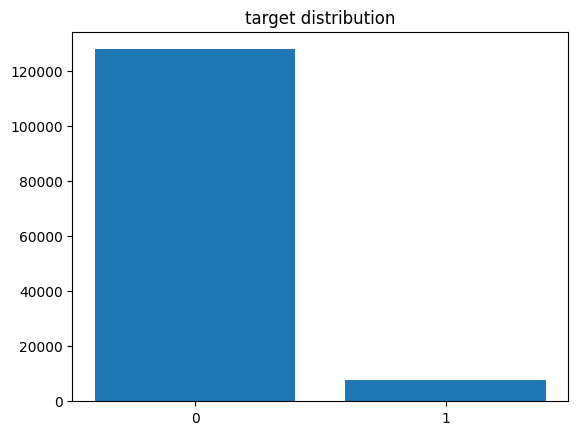

In [52]:
#Visualize fraudulent activities
fraudactivities = client_train.groupby(['target'])['client_id'].count()
plt.bar(x=ds.index, height=ds.values, tick_label =[0,1])
plt.title('target distribution')
plt.show()
#Target is highly imbalanced with fewer cases of fraudulent activities

Our dataset is highly imbalanced. This means the number of non-fraudulent customers (0) 
is significantly greater than the number of fraudulent ones (1). 
This situation is completely normal for fraud detection tasks, but we must pay close attention to it 
when building our model to ensure it doesn't simply predict everything as "non-fraudulent.

In [67]:
client_train.rename(columns={'disrict': 'district'}, inplace=True)
print(client_train.columns)
client_test.rename(columns={'disrict': 'district'}, inplace=True)
print(client_test.columns)

Index(['district', 'client_id', 'client_catg', 'region', 'creation_date',
       'target'],
      dtype='object')
Index(['district', 'client_id', 'client_catg', 'region', 'creation_date'], dtype='object')


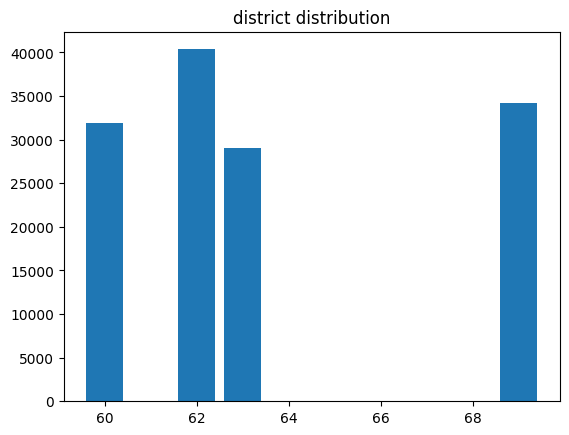

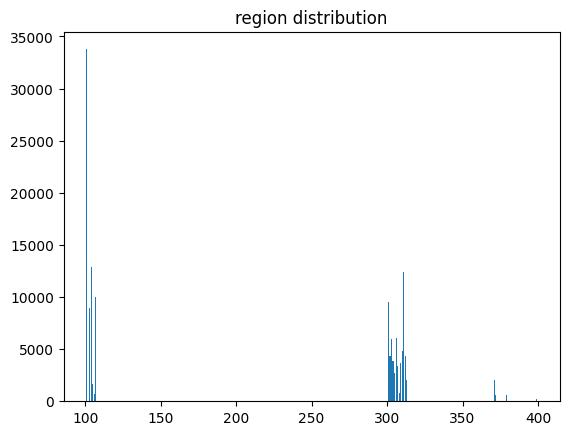

In [68]:
#Visualize client distribution across districts and regions
for col in ['district','region']:
    region = client_train.groupby([col])['client_id'].count()
    plt.bar(x=region.index, height=region.values)
    plt.title(col+' distribution')
    plt.show()

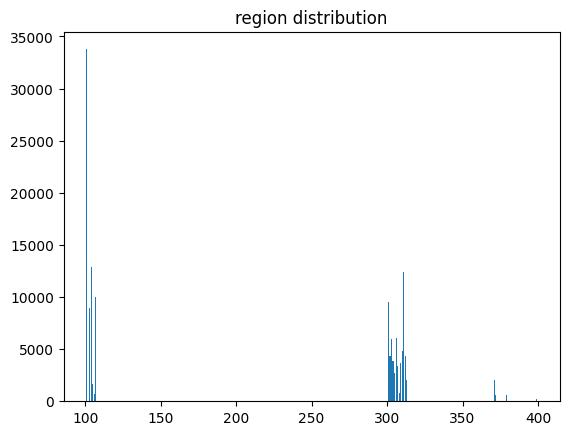

In [34]:
ds = client_train.groupby(['region'])['client_id'].count()
plt.bar(x=ds.index, height=ds.values)
plt.title('region distribution')
plt.show()

# Feature Engineering

In [62]:
# Check the data types of the columns before defining X and y
print(client_train.info())

# Alternatively, specifically find the columns with text (object) data type
object_cols = client_train.select_dtypes(include=['object']).columns
print("Non-numeric columns:", list(object_cols))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 135493 entries, 0 to 135492
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   district       135493 non-null  int64  
 1   client_id      135493 non-null  object 
 2   client_catg    135493 non-null  int64  
 3   region         135493 non-null  int64  
 4   creation_date  135493 non-null  object 
 5   target         135493 non-null  float64
dtypes: float64(1), int64(3), object(2)
memory usage: 6.2+ MB
None
Non-numeric columns: ['client_id', 'creation_date']


In [71]:
#convert the column invoice_date to date time format on both the invoice train and invoice test
for df in [invoice_train,invoice_test]:
    df['invoice_date'] = pd.to_datetime(df['invoice_date'])

In [64]:
#encode labels in categorical column
d={"ELEC":0,"GAZ":1}
invoice_train['counter_type']=invoice_train['counter_type'].map(d)
invoice_test['counter_type']=invoice_test['counter_type'].map(d)

In [69]:
#convert categorical columns to int for model
client_train['client_catg'] = client_train['client_catg'].astype(int)
client_train['district'] = client_train['district'].astype(int)

client_test['client_catg'] = client_test['client_catg'].astype(int)
client_test['district'] = client_test['district'].astype(int)

In [73]:
import pandas as pd

# It's good practice to work on a copy of your dataframe
df_processed = client_train.copy()

# 1. Handle the 'creation_date' column
# Convert the column to a proper datetime format
df_processed['creation_date'] = pd.to_datetime(df_processed['creation_date'])

# Extract numerical features from the date
df_processed['creation_year'] = df_processed['creation_date'].dt.year
df_processed['creation_month'] = df_processed['creation_date'].dt.month
df_processed['creation_dayofweek'] = df_processed['creation_date'].dt.dayofweek

# 2. Define your features (X) and target (y)
# We drop the original date column and the client_id
X = df_processed.drop(columns=['target', 'creation_date', 'client_id'])
y = df_processed['target']

# --- Verification Step ---
# Check the info for X to confirm all columns are now numeric
print("Data types of the final features (X):")
X.info()

Data types of the final features (X):
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 135493 entries, 0 to 135492
Data columns (total 6 columns):
 #   Column              Non-Null Count   Dtype
---  ------              --------------   -----
 0   district            135493 non-null  int64
 1   client_catg         135493 non-null  int64
 2   region              135493 non-null  int64
 3   creation_year       135493 non-null  int32
 4   creation_month      135493 non-null  int32
 5   creation_dayofweek  135493 non-null  int32
dtypes: int32(3), int64(3)
memory usage: 4.7 MB


In [77]:
# --- 2. Feature Engineering & Preprocessing ---


# Handle the 'creation_date' column by extracting numerical features
client_train['creation_date'] = pd.to_datetime(client_train['creation_date'])
client_train['creation_year'] = client_train['creation_date'].dt.year
client_train['creation_month'] = client_train['creation_date'].dt.month
client_train['creation_dayofweek'] = client_train['creation_date'].dt.dayofweek

# Process the invoice data
# Convert invoice_date to datetime
invoice_train['invoice_date'] = pd.to_datetime(invoice_train['invoice_date'])

# Encode 'counter_type' using mapping
d = {"ELEC": 0, "GAZ": 1}
invoice_train['counter_type'] = invoice_train['counter_type'].map(d)

# Aggregate invoice data by client
def aggregate_by_client_id(invoice_data):
    aggs = {
        'consommation_level_1': ['mean'],
        'consommation_level_2': ['mean'],
        'consommation_level_3': ['mean'],
        'consommation_level_4': ['mean'],
        'months_number': ['mean', 'max'] # Added more aggregations for richness
    }
    agg_trans = invoice_data.groupby('client_id').agg(aggs)
    agg_trans.columns = ['_'.join(col).strip() for col in agg_trans.columns.values]
    agg_trans.reset_index(inplace=True)

    df = (invoice_data.groupby('client_id')
            .size()
            .reset_index(name='transactions_count'))
    
    return pd.merge(df, agg_trans, on='client_id', how='left')

agg_train = aggregate_by_client_id(invoice_train)

# Merge aggregated invoice data with client data
train_df = pd.merge(client_train, agg_train, on='client_id', how='left')



In [78]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, precision_recall_curve, auc


# Drop unnecessary columns
# 'creation_date' is now represented by numerical features
# 'client_id' is an identifier and not a feature
X = train_df.drop(columns=['target', 'creation_date', 'client_id'])
y = train_df['target']

# Assuming X is the feature data and y are the labels (0 and 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Build the baseline model
# class_weight='balanced' automatically gives a higher weight to the minority class (1)
baseline_model = LogisticRegression(class_weight='balanced', solver='liblinear')

# Train the model
baseline_model.fit(X_train, y_train)

# Make predictions
y_pred = baseline_model.predict(X_test)

# Evaluation
print(classification_report(y_test, y_pred))

# Calculate AUC-PR
y_probs = baseline_model.predict_proba(X_test)[:, 1] # Probability of belonging to class 1
precision, recall, _ = precision_recall_curve(y_test, y_probs)
print(f"AUC-PR Score: {auc(recall, precision)}")

              precision    recall  f1-score   support

         0.0       0.97      0.67      0.79     38378
         1.0       0.10      0.60      0.17      2270

    accuracy                           0.67     40648
   macro avg       0.53      0.63      0.48     40648
weighted avg       0.92      0.67      0.76     40648

AUC-PR Score: 0.09835572811167444


# Our baseline model Interpretation:
Good Recall (0.60 for fraud): The model is effective at catching a majority of the actual fraudsters, identifying 60% of all fraudulent cases. This is a strong starting point.

Very Poor Precision (0.10 for fraud): This is the main weakness. When the model predicts an account is fraudulent, it is only correct 10% of the time. This leads to a high number of false positives, meaning many legitimate customers would be incorrectly flagged.

Low AUC-PR Score (0.098): This score confirms that while the model is better than random, its overall ability to balance finding fraud (recall) and being accurate (precision) is low.

In short: The model is good at finding fraud but is overly sensitive, resulting in too many false alarms. The next step is to improve its precision without significantly hurting its ability to recall fraudulent cases.

In [79]:
print(baseline_model.coef_)
print(baseline_model.intercept_)

[[ 5.36066142e-03  3.12684874e-03  4.56512621e-04 -7.41089849e-04
  -3.76431606e-04  1.47907101e-05  2.29404687e-02  2.47541608e-05
   4.02898535e-06  3.19919966e-03 -5.45631155e-05 -8.95143995e-05
   3.56160036e-05]]
[4.19052693e-06]
